Pour évaluer la stabilité de segmentation dans le temps : choisir une segmentation, le plus simple sera celle faite via kmeans.
Faire un kmeans sur une période de référence (probablement une année complète).
Faire ensuite glisser les périodes : M+1, M+2, M+3, etc
Utiliser le kmeans de la période de référence pour prédire les clusters sur les périodes glissantes.
Comparer les clusters prédits avec les clusters si on avait réentrainer le modèle sur la période glissante.
Faire une matrice de confusion pour voir comment se répartissent les clients.
Calculer l'indice de rand ajusté (class sklearn.metrics)
En déduire quand la segmentation doit etre mise à jour.


In [39]:

# train model sur des données puis Mois + 1 / M + 2
# kmeans (pickle) : load / predict / checker ARI score : si stable ou si ca change bcp et là doit refit

# bdd order_purchase / max - 1 mois avant / reprend tout et fit

# 3 sep
# fit bdd 3 / 08 - reprend bdd entiere predict 3/09 - / ARI (normalement decroissant)
# fit 03/07 / predict bdd / ARI
# nombre de mois : janvier / M+8 / lineplot (inf à 0.8/0.7 apres trois mois)

# trois 112000 / retirer les mois recents puis groupby // ne pas prendre les nouveaux clients (verifier si le modele tient sur la distance/ meme clients mais caracteristique diff)

# dbscan

### Importing libraries

In [40]:
import pandas as pd
%reset -f

from simulation_functions import *
from functions import *

%matplotlib inline
%autosave 300

Autosaving every 300 seconds


In [41]:
# Starting time
t0 = time()

input_path = "./dataset/cleaned/"
input_filename = "merged_dataset.csv"

simulation_path = "./dataset/simulation/"
experiment_1_path = simulation_path + "/experiment_1/"
experiment_2_path = simulation_path + "/experiment_2/"

### Importing dataset

In [42]:
data = load_data(input_path, input_filename)

___Loading raw dataset___
Initial shape : (112650, 18)


In [43]:
data

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,1,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,1,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,1,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112645,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00,da62f9e57a76d978d02ab5362c509660,11722,praia grande,SP,1,f1d4ce8c6dd66c47bbaa8c6781c2a923,1f9ab4708f3056ede07124aad39a2554,2018-02-12 13:10:37,174.90,20.10
112646,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00,737520a9aad80b3fbbdad19b66b37b30,45920,nova vicosa,BA,1,b80910977a37536adeddd63663f916ad,d50d79cb34e38265a8649c383dcffd48,2017-09-05 15:04:16,205.99,65.02
112647,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00,5097a5312c8b157bb7be58ae360ef43c,28685,japuiba,RJ,1,d1c427060a0f73f6b889a5c7c61f2ac4,a1043bafd471dff536d0c462352beb48,2018-01-12 21:36:21,179.99,40.59
112648,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00,5097a5312c8b157bb7be58ae360ef43c,28685,japuiba,RJ,2,d1c427060a0f73f6b889a5c7c61f2ac4,a1043bafd471dff536d0c462352beb48,2018-01-12 21:36:21,179.99,40.59


## I) Preparing simulation datasets

In [44]:
data['order_purchase_timestamp'] = pd.to_datetime(data['order_purchase_timestamp'].astype(str), format='%Y/%m/%d') # .astype(str)

In [45]:
last_day_recorded = data["order_purchase_timestamp"].max()

print("Last day recorded in the dataset :", last_day_recorded, type(last_day_recorded))

print("Year :", last_day_recorded.year)
print("Month :", last_day_recorded.month)
print("Day :", last_day_recorded.day)

Last day recorded in the dataset : 2018-09-03 09:06:57 <class 'pandas._libs.tslibs.timestamps.Timestamp'>
Year : 2018
Month : 9
Day : 3


In [46]:
nb_days = 15

In [47]:
# Time limit
time_limit = max(data.order_purchase_timestamp) + relativedelta(days=-nb_days)

time_limit

Timestamp('2018-08-19 09:06:57')

In [48]:
data_previous_days = data.copy()
filter_date = data_previous_days["order_purchase_timestamp"] <= time_limit

data_previous_days = data_previous_days[filter_date]
print("Verification of the filter :", max(data_previous_days.order_purchase_timestamp))

Verification of the filter : 2018-08-19 08:57:45


In [49]:
data_previous_days = data_previous_days.groupby('customer_unique_id').agg({'order_purchase_timestamp' : lambda x: (time_limit - x.max()).days,
                                           'order_id' : pd.Series.nunique,
                                           'price' : 'sum',
                                           })
# Rename columns
dataset_rfm_previous_days = data_previous_days.rename(columns = {'order_purchase_timestamp' : 'Recency',
                                   'order_id' : 'Frequency',
                                   'price' : 'Monetary'}) #, inplace = True)

In [50]:
dataset_rfm_previous_days

,Recency,Frequency,Monetary
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,100,1,129.90
0000b849f77a49e4a4ce2b2a4ca5be3f,103,1,18.90
0000f46a3911fa3c0805444483337064,526,1,69.00
0000f6ccb0745a6a4b88665a16c9f078,310,1,25.99
0004aac84e0df4da2b147fca70cf8255,277,1,180.00
...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,436,1,1570.00
fffea47cd6d3cc0a88bd621562a9d061,251,1,64.89
ffff371b4d645b6ecea244b27531430a,557,1,89.90


## II) Simulation

### Simulation 1 : simulation over 6 months

In [51]:
nb_periods_exp_1 = 17
nb_days_exp_1 = 15

##### Experiment 1 : We create datasets and csv files over 6 months

In [52]:
simulate_dataset(data, nb_days=nb_days_exp_1, nb_periods=nb_periods_exp_1, output_path=experiment_1_path, experiment_nb=1)




Step : 1 Maximum order purchase date : 2017-12-22 09:06:57
Verification of the filter : 2017-12-22 09:06:20
This dataset has 42415 unique clients



Step : 2 Maximum order purchase date : 2018-01-06 09:06:57
Verification of the filter : 2018-01-06 09:03:41
This dataset has 44483 unique clients



Step : 3 Maximum order purchase date : 2018-01-21 09:06:57
Verification of the filter : 2018-01-21 09:03:17
This dataset has 48074 unique clients



Step : 4 Maximum order purchase date : 2018-02-05 09:06:57
Verification of the filter : 2018-02-05 09:06:12
This dataset has 51346 unique clients



Step : 5 Maximum order purchase date : 2018-02-20 09:06:57
Verification of the filter : 2018-02-20 09:05:49
This dataset has 54669 unique clients



Step : 6 Maximum order purchase date : 2018-03-07 09:06:57
Verification of the filter : 2018-03-07 09:02:41
This dataset has 58414 unique clients



Step : 7 Maximum order purchase date : 2018-03-22 09:06:57
Verification of the filter : 2018-03-22 08:4

In [53]:
X_T0 = pd.read_csv(experiment_1_path + "rfm_T0.csv").drop("customer_unique_id", axis=1).copy()

In [54]:
X_T0

,Recency,Frequency,Monetary
0,286,1,69.00
1,70,1,25.99
2,37,1,180.00
3,292,1,135.00
4,156,1,13.90
...,...,...,...
42410,4,1,58.00
42411,196,1,1570.00
42412,11,1,64.89
42413,317,1,89.90


In [55]:
scaler = StandardScaler().fit(X_T0[X_T0.columns])

X_std_T0 = X_T0.copy()
X_std_T0[X_std_T0.columns] = scaler.transform(X_std_T0[X_std_T0.columns])
print(X_std_T0.shape)

X_std_T0

(42415, 3)


,Recency,Frequency,Monetary
0,1.568474,-0.160436,-0.327221
1,-0.646025,-0.160436,-0.516989
2,-0.984351,-0.160436,0.162531
3,1.629988,-0.160436,-0.036017
4,0.235674,-0.160436,-0.570333
...,...,...,...
42410,-1.322678,-0.160436,-0.375755
42411,0.645766,-0.160436,6.295468
42412,-1.250912,-0.160436,-0.345355
42413,1.886296,-0.160436,-0.235007


#### PCA

In [56]:
from sklearn.decomposition import PCA

pca_T0 = PCA(n_components=2, random_state=0)
pca_T0.fit(X_std_T0)
print(pca_T0.explained_variance_ratio_.cumsum())

X_pca_T0 = pca_T0.transform(X_std_T0)

[0.3645731  0.69904393]


(-0.7, 0.7)

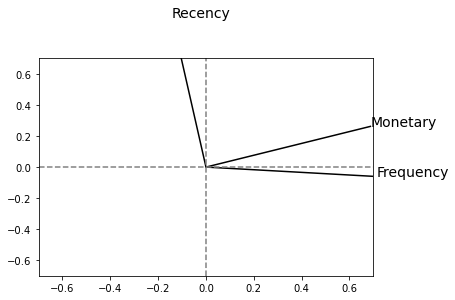

In [57]:
pcs = pca_T0.components_

for i, (x, y) in enumerate(zip(pcs[0, :], pcs[1, :])):
    # Afficher un segment de l'origine au point (x, y)
    plt.plot([0, x], [0, y], color='k')
    # Afficher le nom (data.columns[i]) de la performance
    plt.text(x, y, X_std_T0.columns[i], fontsize='14')

# Afficher une ligne horizontale y=0
plt.plot([-0.7, 0.7], [0, 0], color='grey', ls='--')

# Afficher une ligne verticale x=0
plt.plot([0, 0], [-0.7, 0.7], color='grey', ls='--')

plt.xlim([-0.7, 0.7])
plt.ylim([-0.7, 0.7])

#### K-Means

In [58]:
from sklearn.cluster import KMeans

kmeans_cls_T0 = KMeans(n_clusters=5, verbose=0, random_state=0)
kmeans_cls_T0.fit(X_std_T0)

KMeans(n_clusters=5, random_state=0)

Text(0.5, 1.0, 'Visualizing clusters with PCA')

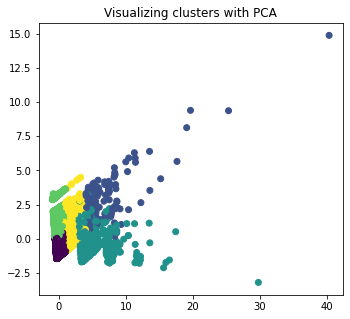

In [59]:
fig = plt.figure(figsize=(12, 5))

ax = fig.add_subplot(121) # 1 en ordonnée / 2 en abcs / celle là la premiere
ax.scatter(x=X_pca_T0[:, 0], y=X_pca_T0[:, 1], c=kmeans_cls_T0.labels_) # colorier en fct etiquette deu clusterning
plt.title("Visualizing clusters with PCA")

#### T1 = T0 + 15 days

In [60]:
X_T1 = pd.read_csv(experiment_1_path + "/rfm_T1.csv").drop("customer_unique_id", axis=1).copy()

In [61]:
X_std_T1 = X_T1.copy()
scaler = StandardScaler()

X_std_T1[X_std_T1.columns] = scaler.fit_transform(X_std_T1)
print(X_std_T1.shape)

(44483, 3)


In [62]:
kmeans_cls_T1_new = KMeans(n_clusters=5, verbose=0, random_state=0)
kmeans_cls_T1_new.fit(X_std_T1)

KMeans(n_clusters=5, random_state=0)

In [63]:
kmeans_cls_T1_init = kmeans_cls_T0.predict(X_std_T1)

In [64]:
kmeans_cls_T1_new.labels_

array([2, 1, 1, ..., 1, 2, 2])

In [65]:
kmeans_cls_T1_init

array([3, 0, 0, ..., 0, 3, 3])

In [66]:
ARI_T1 = adjusted_rand_score(kmeans_cls_T1_init, kmeans_cls_T1_new.labels_) # Y true labels / pred labels
ARI_T1

0.9895877776973669

#### Evaluate ARI for all T (all periods)

In [67]:
simulation_results_exp_1 = pd.DataFrame({})

simulation_results_exp_1 = run_simulation(nb_periods=nb_periods_exp_1, kmeans_cls_T0=kmeans_cls_T0, results=simulation_results_exp_1, experiment_nb=1)




For T = 1
(44483, 3)
We make a new clustering using that fits the new dataset.
KMeans(n_clusters=5, random_state=0)
We predict a clustering using the clustering at T0 for the new dataset.
ARI for T = 1


,T,ARI
0,1,0.989588





For T = 2
(48074, 3)
We make a new clustering using that fits the new dataset.
KMeans(n_clusters=5, random_state=0)
We predict a clustering using the clustering at T0 for the new dataset.
ARI for T = 2


,T,ARI
0,1,0.989588
1,2,0.999194





For T = 3
(51346, 3)
We make a new clustering using that fits the new dataset.
KMeans(n_clusters=5, random_state=0)
We predict a clustering using the clustering at T0 for the new dataset.
ARI for T = 3


,T,ARI
0,1,0.989588
1,2,0.999194
2,3,0.997099





For T = 4
(54669, 3)
We make a new clustering using that fits the new dataset.
KMeans(n_clusters=5, random_state=0)
We predict a clustering using the clustering at T0 for the new dataset.
ARI for T = 4


,T,ARI
0,1,0.989588
1,2,0.999194
2,3,0.997099
3,4,0.948746





For T = 5
(58414, 3)
We make a new clustering using that fits the new dataset.
KMeans(n_clusters=5, random_state=0)
We predict a clustering using the clustering at T0 for the new dataset.
ARI for T = 5


,T,ARI
0,1,0.989588
1,2,0.999194
2,3,0.997099
3,4,0.948746
4,5,0.963313





For T = 6
(61879, 3)
We make a new clustering using that fits the new dataset.
KMeans(n_clusters=5, random_state=0)
We predict a clustering using the clustering at T0 for the new dataset.
ARI for T = 6


,T,ARI
0,1,0.989588
1,2,0.999194
2,3,0.997099
3,4,0.948746
4,5,0.963313
5,6,0.908967





For T = 7
(65121, 3)
We make a new clustering using that fits the new dataset.
KMeans(n_clusters=5, random_state=0)
We predict a clustering using the clustering at T0 for the new dataset.
ARI for T = 7


,T,ARI
0,1,0.989588
1,2,0.999194
2,3,0.997099
3,4,0.948746
4,5,0.963313
5,6,0.908967
6,7,0.924969





For T = 8
(68407, 3)
We make a new clustering using that fits the new dataset.
KMeans(n_clusters=5, random_state=0)
We predict a clustering using the clustering at T0 for the new dataset.
ARI for T = 8


,T,ARI
0,1,0.989588
1,2,0.999194
2,3,0.997099
3,4,0.948746
4,5,0.963313
5,6,0.908967
6,7,0.924969
7,8,0.917478





For T = 9
(71881, 3)
We make a new clustering using that fits the new dataset.
KMeans(n_clusters=5, random_state=0)
We predict a clustering using the clustering at T0 for the new dataset.
ARI for T = 9


,T,ARI
0,1,0.989588
1,2,0.999194
2,3,0.997099
3,4,0.948746
4,5,0.963313
5,6,0.908967
6,7,0.924969
7,8,0.917478
8,9,0.908843





For T = 10
(75772, 3)
We make a new clustering using that fits the new dataset.
KMeans(n_clusters=5, random_state=0)
We predict a clustering using the clustering at T0 for the new dataset.
ARI for T = 10


,T,ARI
0,1,0.989588
1,2,0.999194
2,3,0.997099
3,4,0.948746
4,5,0.963313
5,6,0.908967
6,7,0.924969
7,8,0.917478
8,9,0.908843
9,10,0.919714





For T = 11
(77917, 3)
We make a new clustering using that fits the new dataset.
KMeans(n_clusters=5, random_state=0)
We predict a clustering using the clustering at T0 for the new dataset.
ARI for T = 11


,T,ARI
0,1,0.989588
1,2,0.999194
2,3,0.997099
3,4,0.948746
4,5,0.963313
5,6,0.908967
6,7,0.924969
7,8,0.917478
8,9,0.908843
9,10,0.919714





For T = 12
(81013, 3)
We make a new clustering using that fits the new dataset.
KMeans(n_clusters=5, random_state=0)
We predict a clustering using the clustering at T0 for the new dataset.
ARI for T = 12


,T,ARI
0,1,0.989588
1,2,0.999194
2,3,0.997099
3,4,0.948746
4,5,0.963313
5,6,0.908967
6,7,0.924969
7,8,0.917478
8,9,0.908843
9,10,0.919714





For T = 13
(83964, 3)
We make a new clustering using that fits the new dataset.
KMeans(n_clusters=5, random_state=0)
We predict a clustering using the clustering at T0 for the new dataset.
ARI for T = 13


,T,ARI
0,1,0.989588
1,2,0.999194
2,3,0.997099
3,4,0.948746
4,5,0.963313
5,6,0.908967
6,7,0.924969
7,8,0.917478
8,9,0.908843
9,10,0.919714





For T = 14
(86403, 3)
We make a new clustering using that fits the new dataset.
KMeans(n_clusters=5, random_state=0)
We predict a clustering using the clustering at T0 for the new dataset.
ARI for T = 14


,T,ARI
0,1,0.989588
1,2,0.999194
2,3,0.997099
3,4,0.948746
4,5,0.963313
5,6,0.908967
6,7,0.924969
7,8,0.917478
8,9,0.908843
9,10,0.919714





For T = 15
(90092, 3)
We make a new clustering using that fits the new dataset.
KMeans(n_clusters=5, random_state=0)
We predict a clustering using the clustering at T0 for the new dataset.
ARI for T = 15


,T,ARI
0,1,0.989588
1,2,0.999194
2,3,0.997099
3,4,0.948746
4,5,0.963313
5,6,0.908967
6,7,0.924969
7,8,0.917478
8,9,0.908843
9,10,0.919714





For T = 16
(94102, 3)
We make a new clustering using that fits the new dataset.
KMeans(n_clusters=5, random_state=0)
We predict a clustering using the clustering at T0 for the new dataset.
ARI for T = 16


,T,ARI
0,1,0.989588
1,2,0.999194
2,3,0.997099
3,4,0.948746
4,5,0.963313
5,6,0.908967
6,7,0.924969
7,8,0.917478
8,9,0.908843
9,10,0.919714





For T = 17
(95420, 3)
We make a new clustering using that fits the new dataset.
KMeans(n_clusters=5, random_state=0)
We predict a clustering using the clustering at T0 for the new dataset.
ARI for T = 17


,T,ARI
0,1,0.989588
1,2,0.999194
2,3,0.997099
3,4,0.948746
4,5,0.963313
5,6,0.908967
6,7,0.924969
7,8,0.917478
8,9,0.908843
9,10,0.919714


In [68]:
simulation_results_exp_1

,T,ARI
0,1,0.989588
1,2,0.999194
2,3,0.997099
3,4,0.948746
4,5,0.963313
5,6,0.908967
6,7,0.924969
7,8,0.917478
8,9,0.908843
9,10,0.919714


(0.19999999999999996, 17.8, 0.3833376139432198, 1.0285201841307254)

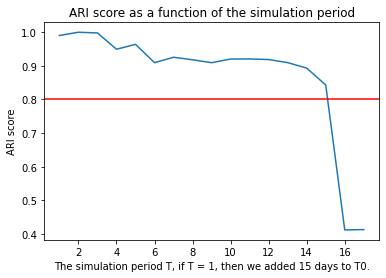

In [69]:
sns.lineplot(data=simulation_results_exp_1, x="T", y="ARI")
# specifying horizontal line type
plt.axhline(y=0.8, color='r', linestyle='-')

plt.xlabel('The simulation period T, if T = 1, then we added {} days to T0.'.format(nb_days_exp_1))
plt.ylabel('ARI score')
plt.title('ARI score as a function of the simulation period')
plt.axis('tight')

### Simulation 2 : we take a period closer to the max purchase order date

In [70]:
#T = 10 == un mois avant
nb_periods_exp_2 = 16 # quatre mois avant
nb_days_exp_2 = 7

In [71]:
simulate_dataset(data, nb_days=nb_days_exp_2, nb_periods=nb_periods_exp_2, output_path=experiment_2_path, experiment_nb=2)




Step : 1 Maximum order purchase date : 2018-05-14 09:06:57
Verification of the filter : 2018-05-14 09:01:37
This dataset has 73994 unique clients



Step : 2 Maximum order purchase date : 2018-05-21 09:06:57
Verification of the filter : 2018-05-21 08:55:06
This dataset has 75772 unique clients



Step : 3 Maximum order purchase date : 2018-05-28 09:06:57
Verification of the filter : 2018-05-28 09:03:49
This dataset has 76663 unique clients



Step : 4 Maximum order purchase date : 2018-06-04 09:06:57
Verification of the filter : 2018-06-04 08:58:43
This dataset has 77708 unique clients



Step : 5 Maximum order purchase date : 2018-06-11 09:06:57
Verification of the filter : 2018-06-11 08:58:16
This dataset has 79092 unique clients



Step : 6 Maximum order purchase date : 2018-06-18 09:06:57
Verification of the filter : 2018-06-18 08:59:45
This dataset has 80547 unique clients



Step : 7 Maximum order purchase date : 2018-06-25 09:06:57
Verification of the filter : 2018-06-25 09:0

In [72]:
X_T0_exp_2 = pd.read_csv(experiment_2_path + "rfm_T0.csv").drop("customer_unique_id", axis=1).copy()

scaler = StandardScaler().fit(X_T0_exp_2[X_T0_exp_2.columns])

X_std_T0_exp_2 = X_T0_exp_2.copy()
X_std_T0_exp_2[X_std_T0_exp_2.columns] = scaler.transform(X_std_T0_exp_2[X_std_T0_exp_2.columns])
print(X_std_T0_exp_2.shape)

(73994, 3)


In [73]:
kmeans_cls_T0_exp_2 = KMeans(n_clusters=5, verbose=0, random_state=0)
kmeans_cls_T0_exp_2.fit(X_std_T0_exp_2)

KMeans(n_clusters=5, random_state=0)

In [74]:
simulation_results_exp_2 = pd.DataFrame({})
simulation_results_exp_2 = run_simulation(nb_periods=nb_periods_exp_2, kmeans_cls_T0=kmeans_cls_T0_exp_2, results=simulation_results_exp_2, experiment_nb=2)




For T = 1
(75772, 3)
We make a new clustering using that fits the new dataset.
KMeans(n_clusters=5, random_state=0)
We predict a clustering using the clustering at T0 for the new dataset.
ARI for T = 1


,T,ARI
0,1,0.998654





For T = 2
(76663, 3)
We make a new clustering using that fits the new dataset.
KMeans(n_clusters=5, random_state=0)
We predict a clustering using the clustering at T0 for the new dataset.
ARI for T = 2


,T,ARI
0,1,0.998654
1,2,0.985059





For T = 3
(77708, 3)
We make a new clustering using that fits the new dataset.
KMeans(n_clusters=5, random_state=0)
We predict a clustering using the clustering at T0 for the new dataset.
ARI for T = 3


,T,ARI
0,1,0.998654
1,2,0.985059
2,3,0.989281





For T = 4
(79092, 3)
We make a new clustering using that fits the new dataset.
KMeans(n_clusters=5, random_state=0)
We predict a clustering using the clustering at T0 for the new dataset.
ARI for T = 4


,T,ARI
0,1,0.998654
1,2,0.985059
2,3,0.989281
3,4,0.991187





For T = 5
(80547, 3)
We make a new clustering using that fits the new dataset.
KMeans(n_clusters=5, random_state=0)
We predict a clustering using the clustering at T0 for the new dataset.
ARI for T = 5


,T,ARI
0,1,0.998654
1,2,0.985059
2,3,0.989281
3,4,0.991187
4,5,0.989291





For T = 6
(81949, 3)
We make a new clustering using that fits the new dataset.
KMeans(n_clusters=5, random_state=0)
We predict a clustering using the clustering at T0 for the new dataset.
ARI for T = 6


,T,ARI
0,1,0.998654
1,2,0.985059
2,3,0.989281
3,4,0.991187
4,5,0.989291
5,6,0.988850





For T = 7
(83297, 3)
We make a new clustering using that fits the new dataset.
KMeans(n_clusters=5, random_state=0)
We predict a clustering using the clustering at T0 for the new dataset.
ARI for T = 7


,T,ARI
0,1,0.998654
1,2,0.985059
2,3,0.989281
3,4,0.991187
4,5,0.989291
5,6,0.988850
6,7,0.990098





For T = 8
(84460, 3)
We make a new clustering using that fits the new dataset.
KMeans(n_clusters=5, random_state=0)
We predict a clustering using the clustering at T0 for the new dataset.
ARI for T = 8


,T,ARI
0,1,0.998654
1,2,0.985059
2,3,0.989281
3,4,0.991187
4,5,0.989291
5,6,0.988850
6,7,0.990098
7,8,0.981701





For T = 9
(85421, 3)
We make a new clustering using that fits the new dataset.
KMeans(n_clusters=5, random_state=0)
We predict a clustering using the clustering at T0 for the new dataset.
ARI for T = 9


,T,ARI
0,1,0.998654
1,2,0.985059
2,3,0.989281
3,4,0.991187
4,5,0.989291
5,6,0.988850
6,7,0.990098
7,8,0.981701
8,9,0.984943





For T = 10
(87030, 3)
We make a new clustering using that fits the new dataset.
KMeans(n_clusters=5, random_state=0)
We predict a clustering using the clustering at T0 for the new dataset.
ARI for T = 10


,T,ARI
0,1,0.998654
1,2,0.985059
2,3,0.989281
3,4,0.991187
4,5,0.989291
5,6,0.988850
6,7,0.990098
7,8,0.981701
8,9,0.984943
9,10,0.979649





For T = 11
(88614, 3)
We make a new clustering using that fits the new dataset.
KMeans(n_clusters=5, random_state=0)
We predict a clustering using the clustering at T0 for the new dataset.
ARI for T = 11


,T,ARI
0,1,0.998654
1,2,0.985059
2,3,0.989281
3,4,0.991187
4,5,0.989291
5,6,0.988850
6,7,0.990098
7,8,0.981701
8,9,0.984943
9,10,0.979649





For T = 12
(90601, 3)
We make a new clustering using that fits the new dataset.
KMeans(n_clusters=5, random_state=0)
We predict a clustering using the clustering at T0 for the new dataset.
ARI for T = 12


,T,ARI
0,1,0.998654
1,2,0.985059
2,3,0.989281
3,4,0.991187
4,5,0.989291
5,6,0.988850
6,7,0.990098
7,8,0.981701
8,9,0.984943
9,10,0.979649





For T = 13
(92516, 3)
We make a new clustering using that fits the new dataset.
KMeans(n_clusters=5, random_state=0)
We predict a clustering using the clustering at T0 for the new dataset.
ARI for T = 13


,T,ARI
0,1,0.998654
1,2,0.985059
2,3,0.989281
3,4,0.991187
4,5,0.989291
5,6,0.988850
6,7,0.990098
7,8,0.981701
8,9,0.984943
9,10,0.979649





For T = 14
(94311, 3)
We make a new clustering using that fits the new dataset.
KMeans(n_clusters=5, random_state=0)
We predict a clustering using the clustering at T0 for the new dataset.
ARI for T = 14


,T,ARI
0,1,0.998654
1,2,0.985059
2,3,0.989281
3,4,0.991187
4,5,0.989291
5,6,0.988850
6,7,0.990098
7,8,0.981701
8,9,0.984943
9,10,0.979649





For T = 15
(95314, 3)
We make a new clustering using that fits the new dataset.
KMeans(n_clusters=5, random_state=0)
We predict a clustering using the clustering at T0 for the new dataset.
ARI for T = 15


,T,ARI
0,1,0.998654
1,2,0.985059
2,3,0.989281
3,4,0.991187
4,5,0.989291
5,6,0.988850
6,7,0.990098
7,8,0.981701
8,9,0.984943
9,10,0.979649





For T = 16
(95420, 3)
We make a new clustering using that fits the new dataset.
KMeans(n_clusters=5, random_state=0)
We predict a clustering using the clustering at T0 for the new dataset.
ARI for T = 16


,T,ARI
0,1,0.998654
1,2,0.985059
2,3,0.989281
3,4,0.991187
4,5,0.989291
5,6,0.988850
6,7,0.990098
7,8,0.981701
8,9,0.984943
9,10,0.979649


(0.25, 16.75, 0.37617027495373234, 1.0282958270804592)

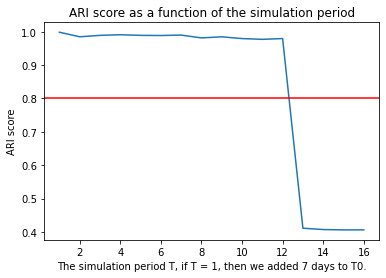

In [75]:
sns.lineplot(data=simulation_results_exp_2, x="T", y="ARI")
# specifying horizontal line type
plt.axhline(y=0.8, color='r', linestyle='-')

plt.xlabel('The simulation period T, if T = 1, then we added {} days to T0.'.format(nb_days_exp_2))
plt.ylabel('ARI score')
plt.title('ARI score as a function of the simulation period')
plt.axis('tight')

In [76]:
adjusted_rand_score([0, 0, 1, 2], [0, 0, 1, 1])

0.5714285714285714